# Demonstration of Multi-Arm Bandit using the Agent Framework

In [1]:
import nxsdk.api.n2a as nx
import os
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
import sys

In [2]:
from banditAgent import Bandit

First we will start off by selecting the true parameters of reward for each arm following a Bernoulli distribution (rewards of 1 or 0, with the parameter being probability of a 1).

In [3]:
#seed RNG for consistency
rs = RandomState(378902)

In [4]:
n_actions = 5
epsilon = 0.10

In [5]:
"""
Choose a distribution of probabilities with one 'arm' the highest, another close behind it (by the 'gap'),
and the rest falling under the second higheset and minimum.
"""
def get_rewards(rand_state, n_actions, lowest_r, highest_r, gap):
    
    highest = rand_state.randint(lowest_r, highest_r, 1)
    second_highest = highest - gap
    rest = rand_state.randint(0, second_highest, n_actions-2)
    
    probabilities = np.concatenate((highest, second_highest, rest))
    rand_state.shuffle(probabilities)
    
    return probabilities/100

In [6]:
probabilities = get_rewards(rs, n_actions, 50, 60, 10)
optimal_arm = np.argmax(probabilities)

Text(0,0.5,'Probability of Reward')

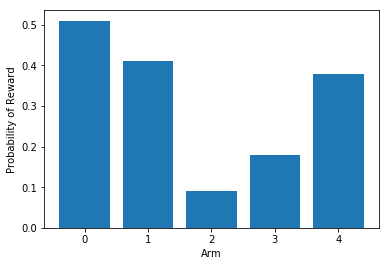

In [7]:
plt.bar(np.arange(0,n_actions), probabilities)
plt.xlabel("Arm")
plt.ylabel("Probability of Reward")

Now, we set the parameters for the spiking agent. It will sample for 2000 epochs, with a period of 128 cycles for each to estimate the best arm

In [8]:
l_epoch = 128
episodes = 2000
runs = 1

In [9]:
#create the bandit using these settings
bandit = Bandit(probabilities, n_replicates=2, n_epochs = episodes, dynrange=2)

In [10]:
#set a probe to record the spikes from its continuous estimations of value
ctx_spks = bandit.cortex.get_outputs().probe(nx.ProbeParameter.SPIKE)

In [11]:
#run the bandit and disconnect once done
results = []
for i in range(runs):
    results.append(bandit.run())
bandit.board.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:42061
INFO:DRV:      Host server up..............Done 0.21s
INFO:DRV:      Encoding axons/synapses.....Done 0.02s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1599177179.864448
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1599177179.864448/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1599177179.864448/initnetwork_0_0.c.o -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../

Here, we collect the results from running the agent.

In [12]:
actions, rewards, estimates = results[0]

We can look at the actions the agent takes and see that it converges onto the optimal arm with some occasional oscillations away as it continues to sample.

Text(0,0.5,'Mean optimal action over 100 epochs')

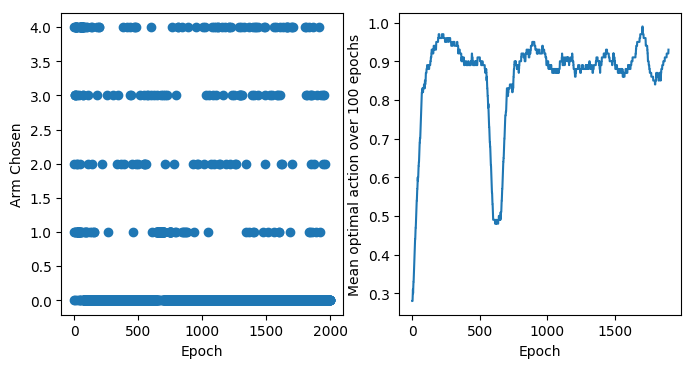

In [21]:
plt.figure(figsize=(8,4),dpi=100)

plt.subplot(121)
plt.scatter(np.arange(episodes), actions)
plt.xlabel("Epoch")
plt.ylabel("Arm Chosen")

plt.subplot(122)
plt.plot(np.convolve((actions == optimal_arm).ravel()*1, np.ones(100), mode='valid')/100)
plt.xlabel("Epoch")
plt.ylabel("Mean optimal action over 100 epochs")

Average reward increases over time as it almost always samples the highest and second-highest arms.

Text(0,0.5,'Average reward over 100 epochs')

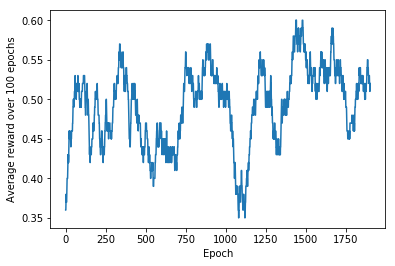

In [14]:
plt.plot(np.convolve((rewards+1)*0.5, np.ones(100), mode='valid')/100)
plt.xlabel("Epoch")
plt.ylabel("Average reward over 100 epochs")

Directly looking at the spike counters which estimate the value of each arm, we can observe the relationship between high firing at the encoder output and the corresponding action being chosen. 

Text(0.5,1,'Estimate of value for each a over time')

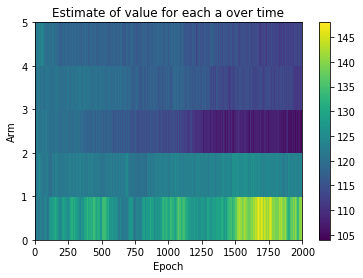

In [15]:
plt.pcolor(estimates.transpose())
plt.colorbar()
plt.xlabel("Epoch")
plt.ylabel("Arm")
plt.title("Estimate of value for each a over time")

In this case, the encoder is counting spikes from multiple sources in the cortex; above, we define n_replicates in the bandit as 2, and this means 2 tracker nodes are being used for each state to provide a quicker estimate of value each epoch.

In [16]:
unwrap = lambda x: x[0].data

Text(0.5,1,'MFR of All Estimate Neurons over Time')

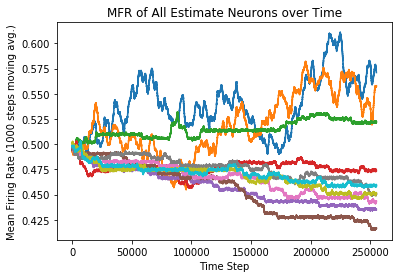

In [17]:
for i in range(10):
    plt.plot(np.convolve(unwrap(ctx_spks)[i,:], np.ones(1000), mode='valid')/1000)
    
plt.xlabel("Time Step")
plt.ylabel("Mean Firing Rate (1000 steps moving avg.)")
plt.title("MFR of All Estimate Neurons over Time")

The two lines in blue and orange above indicate that the two trackers for the highest arm increase their firing rate as they are sampled and found to be above the rest.